# Using core classes

This notebook is just used to illustrate the `VertexAtom` and `Hybridization` classes and the computed values.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [7]:
import numpy as np
import pandas as pd
import pychemcurv
import matplotlib.pyplot as plt
%matplotlib inline

## Utility functions

In [9]:
def build_pyramid(l, theta, n_star_A=3, radians=False, perturb=None):
    """Build a pyramidal geometry given an angle theta and randomize
    the positions by adding a noise of a given magnitude. The vertex of the 
    pyramid is the point A, and *(A) are the points linked to the vertex. The
    size of *(A) is at least 3.

    theta is the angle between the normal vector of the plane define from *(A)
    and one bond between A and *(A). 

       theta = pyrA + 90
     
    Args:
        l (float): the bond lenght
        theta (float): Angle to define the pyramid
        n_star_A (int): number of point bonded to A the vertex of the pyramid.
        radian (bool): True if pyrA in radian (default False)
        perturb (float): Give the width of a normal distribution from which a 
            random number is choosen and added to the cartesian coordinates.
            
    Returns:
        A (4, 3) matrix each row being the coordinates.
    """
    r_theta = theta if radians else np.radians(theta)
    if n_star_A < 3:
        raise ValueError(f"n_star_A = {n_star_A} and must be greater than 3.")
    
    # build an ideal pyramid
    IB = l * np.sin(r_theta)
    step_angle = 2 * np.pi / n_star_A
    coords = [[0, 0, -l * np.cos(r_theta)]]
    coords += [[IB * np.cos(iat * step_angle), IB * np.sin(iat * step_angle), 0] 
               for iat in range(n_star_A)]       
    coords = np.array(coords, dtype=np.float)
    
    # randomize positions
    if perturb:
        coords[1:, :] += np.random.normal(0, perturb, size=(n_star_A, 3))
    
    return coords

In [10]:
def write_xyz(coords, el=["C"], filename="mol.xyz"):
    """ write an xyz file """
    natoms = coords.shape[0]
    if len(el) == 1:
        elements = natoms * el
    elif len(el) == natoms:
        elements = el
    else:
        raise ValueError("Wrong number of elements")
    
    xyz = f"{len(elements)}\nxyz coords\n"
    for element, coord in zip(elements, coords):
        xyz += f"{element}"
        xyz += "".join([f"{x:12.6f}" for x in coord])
        xyz += "\n"
        
    if filename:
        with open(filename, "w") as f:
            f.write(xyz)
    else:
        return xyz

## Compute data for a range of pyrA values

Compute the pyramidalization angle for a series of perfect pyramid of known pyramidalization angle.

In [11]:
l = 1.4
xyz = ""
data = list()
for iline, theta in enumerate(range(90, 90 + 31, 1), 1):
    
    coords = build_pyramid(l, theta, perturb=None)
    
    va = pychemcurv.VertexAtom(coords[0], coords[1:])
    hyb = pychemcurv.Hybridization(va.pyrA)
    
    aline = dict(theta=theta)
    aline.update(va.as_dict())
    aline.update(hyb.as_dict())
    data.append(aline)

    xyz += write_xyz(coords, filename=None)

with open("traj.xyz", "w") as f:
    f.write(xyz)

In [12]:
df = pd.DataFrame(data)
df.head(10)

,theta,pyrA,spherical_curvature,angular_defect,improper,pyr_distance,hybridization,n,m,c_pi^2,lambda_pi^2
0,90,0.000000,8.747477e-17,-8.881784e-16,1.224647e-16,8.572528e-17,2.000000,2.000000,0.000000,0.000000,1.000000
1,91,0.017453,2.493201e-02,1.582437e-03,-3.489596e-02,2.443337e-02,2.001829,2.001829,0.000610,0.000609,0.999391
2,92,0.034907,4.985642e-02,6.324938e-03,-6.972831e-02,4.885930e-02,2.007335,2.007335,0.002445,0.002439,0.997561
3,93,0.052360,7.476565e-02,1.421315e-02,-1.044342e-01,7.327034e-02,2.016570,2.016570,0.005523,0.005493,0.994507
4,94,0.069813,9.965211e-02,2.522338e-02,-1.389524e-01,9.765906e-02,2.029628,2.029628,0.009876,0.009780,0.990220
5,95,0.087266,1.245082e-01,3.932295e-02,-1.732237e-01,1.220180e-01,2.046640,2.046640,0.015547,0.015309,0.984691
6,96,0.104720,1.493264e-01,5.647069e-02,-2.071919e-01,1.463398e-01,2.067779,2.067779,0.022593,0.022094,0.977906
7,97,0.122173,1.740991e-01,7.661746e-02,-2.408041e-01,1.706171e-01,2.093269,2.093269,0.031090,0.030152,0.969848
8,98,0.139626,1.988187e-01,9.970689e-02,-2.740115e-01,1.948423e-01,2.123384,2.123384,0.041128,0.039503,0.960497
9,99,0.157080,2.234778e-01,1.256761e-01,-3.067692e-01,2.190083e-01,2.158464,2.158464,0.052821,0.050171,0.949829


In [13]:
latex = df.to_latex(
    index=False,
    escape=False,
    columns=["theta", "pyrA", "c_pi^2", "lambda_pi^2", "m", "n", "hybridization"],
    formatters={"lambda_pi^2": lambda x: "%8.3f" % x,
                "c_pi^2": lambda x: "%8.3f" % x,
                "m": lambda x: "%8.3f" % x,
                "hybridization": lambda x: "%8.3f" % x,
                "n": lambda x: "%8.3f" % x})
print(latex)

\begin{tabular}{rrrrrrr}
\toprule
 theta &      pyrA &   c_pi^2 & lambda_pi^2 &        m &        n & hybridization \\
\midrule
    90 &  0.000000 &    0.000 &       1.000 &    0.000 &    2.000 &         2.000 \\
    91 &  0.017453 &    0.001 &       0.999 &    0.001 &    2.002 &         2.002 \\
    92 &  0.034907 &    0.002 &       0.998 &    0.002 &    2.007 &         2.007 \\
    93 &  0.052360 &    0.005 &       0.995 &    0.006 &    2.017 &         2.017 \\
    94 &  0.069813 &    0.010 &       0.990 &    0.010 &    2.030 &         2.030 \\
    95 &  0.087266 &    0.015 &       0.985 &    0.016 &    2.047 &         2.047 \\
    96 &  0.104720 &    0.022 &       0.978 &    0.023 &    2.068 &         2.068 \\
    97 &  0.122173 &    0.030 &       0.970 &    0.031 &    2.093 &         2.093 \\
    98 &  0.139626 &    0.040 &       0.960 &    0.041 &    2.123 &         2.123 \\
    99 &  0.157080 &    0.050 &       0.950 &    0.053 &    2.158 &         2.158 \\
   100 &  0.174533 &  

## Compute data for defined pyramid

### A perfect sp3 pyramid

In [14]:
coords = build_pyramid(1.3, np.degrees(np.arccos(-1/3)), perturb=0)
print("coords = \n", coords)
write_xyz(coords, filename="mol.xyz")
va = pychemcurv.VertexAtom(coords[0], coords[1:])
print(f"pyr angle: {va.pyrA:10.4f}")
print(f"pyr distance: {va.pyr_distance:10.4f}")
print(f"angular defect: {va.angular_defect:10.4f}")
print(f"spherical curvature : {va.spherical_curvature}")
print(f"improper angle: {va.improper}")

coords = 
 [[ 0.          0.          0.43333333]
 [ 1.22565175  0.          0.        ]
 [-0.61282588  1.06144556  0.        ]
 [-0.61282588 -1.06144556  0.        ]]
pyr angle:    19.4712
pyr distance:     0.4333
angular defect:     0.5513
spherical curvature : 0.5128205128205127
improper angle: -0.6154797086703873


### A perfect sp2 atom

In [15]:
coords = build_pyramid(1.3, 90, perturb=0)
print("coords = \n", coords)
write_xyz(coords, filename="mol_sp2.xyz")
va = pychemcurv.VertexAtom(coords[0], coords[1:])
print(f"pyr angle: {va.pyrA:10.4f}")
print(f"pyr distance: {va.pyr_distance:10.4f}")
print(f"angular defect: {va.angular_defect:10.4f}")
print(f"spherical curvature : {va.spherical_curvature}")
print(f"improper angle: {va.improper:10.4f}")

coords = 
 [[ 0.00000000e+00  0.00000000e+00 -7.96020419e-17]
 [ 1.30000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.50000000e-01  1.12583302e+00  0.00000000e+00]
 [-6.50000000e-01 -1.12583302e+00  0.00000000e+00]]
pyr angle:     0.0000
pyr distance:     0.0000
angular defect:    -0.0000
spherical curvature : 9.420359993441179e-17
improper angle:     0.0000


### A sp3 pyramid with random noize

Compute the same quantities for a sp3 pyramid but randomize the positions.

#### perturb by 1%

In [16]:
coords = build_pyramid(1.3, np.degrees(np.arccos(-1/3)), perturb=0.01 * 2)
print("coords = \n", coords)
write_xyz(coords, filename="mol_r.xyz")
va = pychemcurv.VertexAtom(coords[0], coords[1:])
print(f"pyr angle: {va.pyrA:10.4f}")
print(f"pyr distance: {va.pyr_distance:10.4f}")
print(f"angular defect: {va.angular_defect:10.4f}")
print(f"spherical curvature : {va.spherical_curvature}")
print(f"improper angle: {va.improper:10.4f}")

coords = 
 [[ 0.00000000e+00  0.00000000e+00  4.33333333e-01]
 [ 1.19623262e+00  1.48214445e-02  2.59774062e-02]
 [-6.23512929e-01  1.07039576e+00  3.33918720e-03]
 [-5.95853887e-01 -1.07012135e+00 -5.86740681e-04]]
pyr angle:    19.1526
pyr distance:     0.4236
angular defect:     0.5347
spherical curvature : 0.5080353452757975
improper angle:    -0.6074


#### Perturb by 15%

Compute the same quantities for a sp3 pyramid but randomize the positions by 15%.

In [17]:
coords = build_pyramid(1.4, np.degrees(np.arccos(-1/3)), perturb=0.15 * 2)
print("coords = \n", coords)
write_xyz(coords, filename="mol_r.xyz")
va = pychemcurv.VertexAtom(coords[0], coords[1:])
print(f"pyr angle: {va.pyrA:10.4f}")
print(f"pyr distance: {va.pyr_distance:10.4f}")
print(f"angular defect: {va.angular_defect:10.4f}")
print(f"spherical curvature : {va.spherical_curvature}")
print(f"improper angle: {va.improper:10.4f}")

coords = 
 [[ 0.          0.          0.46666667]
 [ 1.55257661 -0.63908829 -0.51067063]
 [-0.89539197  1.16502608  0.19347791]
 [-0.83009946 -1.56912125 -0.01756665]]
pyr angle:    18.8158
pyr distance:     0.5505
angular defect:     0.5707
spherical curvature : 0.37160453883770644
improper angle:    -0.8836


### Random rotation

Apply a random rotation and translation to the molecule, and check the results do not change.

In [18]:
# transformation matrix from qr decomposition
q ,r = np.linalg.qr(np.random.random((3, 3)))

# translation vector
translation = np.random.uniform(-10, 10, 3)

# new coordinates
qcoords = np.dot(coords, q) + translation
print("qcoords = \n", qcoords)

write_xyz(qcoords, filename="random.xyz")

va = pychemcurv.VertexAtom(qcoords[0], qcoords[1:])
print(f"pyr angle: {va.pyrA:10.4f}")
print(f"pyr distance: {va.pyr_distance:10.4f}")
print(f"angular defect: {va.angular_defect:10.4f}")
print(f"spherical curvature : {va.spherical_curvature}")
print(f"improper angle: {va.improper:10.4f}")

qcoords = 
 [[-1.86135692  6.7504218   2.79287681]
 [-1.77277756  5.85523808  1.07098367]
 [-2.05536292  6.18380119  4.16216399]
 [-0.09778132  7.20852017  2.53668258]]
pyr angle:    18.8158
pyr distance:     0.5505
angular defect:     0.5707
spherical curvature : 0.37160453883770683
improper angle:    -0.8836


In [19]:
with open("random.xyz", "r") as f:
    nat = int(f.readline())
    f.readline()
    coords = list()
    for iat in range(nat):
        line = f.readline().split()
        coords.append(line[1:4])
coords = np.array(coords, dtype=np.float64)
print(coords)

va = pychemcurv.VertexAtom(qcoords[0], qcoords[1:])
print(f"pyr angle: {va.pyrA}")
print(f"pyr distance: {va.pyr_distance}")
print(f"angular defect: {va.angular_defect}")
print(f"spherical curvature : {va.spherical_curvature}")
print(f"improper angle: {va.improper}")

[[-1.861357  6.750422  2.792877]
 [-1.772778  5.855238  1.070984]
 [-2.055363  6.183801  4.162164]
 [-0.097781  7.20852   2.536683]]
pyr angle: 18.815844849617964
pyr distance: 0.5505463213755868
angular defect: 0.5707402967615947
spherical curvature : 0.37160453883770683
improper angle: -0.883638559660301


## Numpy

The `Hybridization` class can be used with numpy.

In [20]:
pyrA = np.linspace(0, 30, 12)
hyb = pychemcurv.Hybridization(pyrA)

In [21]:
hyb.c_pi ** 2

array([0.        , 0.00453835, 0.01823608, 0.0413444 , 0.07429295,
       0.11770697, 0.17243303, 0.23957508, 0.32054361, 0.41712183,
       0.53155439, 0.66666667])

In [22]:
hyb.lambda_pi ** 2

array([1.        , 0.99546165, 0.98176392, 0.9586556 , 0.92570705,
       0.88229303, 0.82756697, 0.76042492, 0.67945639, 0.58287817,
       0.46844561, 0.33333333])

In [27]:
hyb.as_dict()

{'hybridization': array([2.        , 2.01367713, 2.05572443, 2.12938243, 2.24076606,
        2.40023088, 2.62508428, 2.94516265, 3.41529438, 4.14687311,
        5.40415859, 8.        ]),
 'n': array([2.        , 2.01367713, 2.05572443, 2.12938243, 2.24076606,
        2.40023088, 2.62508428, 2.94516265, 3.41529438, 4.14687311,
        5.40415859, 8.        ]),
 'm': array([0.        , 0.00455904, 0.01857481, 0.04312748, 0.08025535,
        0.13341029, 0.20836143, 0.31505422, 0.47176479, 0.71562437,
        1.13471953, 2.        ]),
 'c_pi^2': array([0.        , 0.00453835, 0.01823608, 0.0413444 , 0.07429295,
        0.11770697, 0.17243303, 0.23957508, 0.32054361, 0.41712183,
        0.53155439, 0.66666667]),
 'lambda_pi^2': array([1.        , 0.99546165, 0.98176392, 0.9586556 , 0.92570705,
        0.88229303, 0.82756697, 0.76042492, 0.67945639, 0.58287817,
        0.46844561, 0.33333333])}

## Hybridization

Calculations of $c_\pi^2 / 3$ and $\lambda_\pi^2$ as a function of $pyrA$.

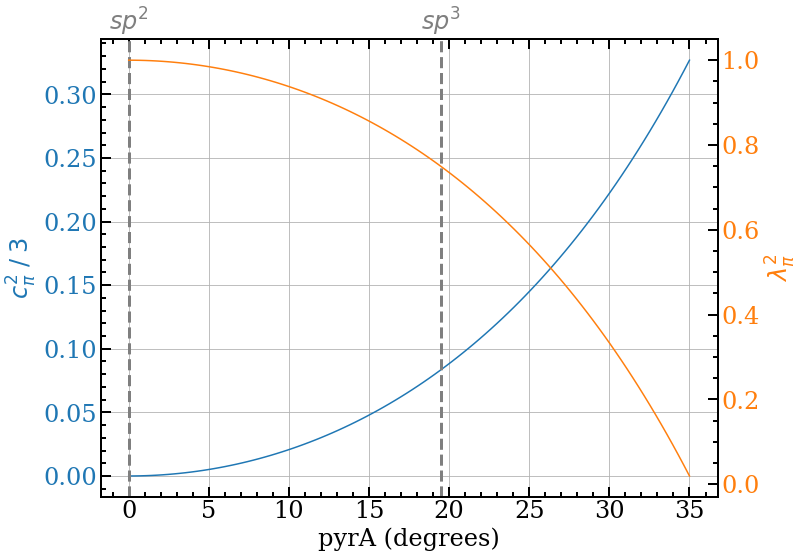

In [24]:
pyrA = np.linspace(0, 35, 100)
hybridization = pychemcurv.Hybridization(pyrA)

with plt.style.context("publi"):
    fig, ax1 = plt.subplots()
    
    ax1.plot(pyrA, hybridization.c_pi ** 2 / 3, label="$p_z$ weight in $\sigma$ orbitals")
    ax1.set_xlabel('pyrA (degrees)')
    ax1.set_ylabel('$c_\pi^2 \; / \; 3$', color="C0")
    ax1.tick_params(axis='y', labelcolor="C0")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(pyrA, hybridization.lambda_pi **2, color="C1", label="s weight in $\pi$ orbital")
    
    ax2.set_ylabel('$\lambda_\pi^2$', color="C1")
    ax2.tick_params(axis='y', labelcolor="C1")
    
    ax1.axvline(0, color="C7", ls="--", lw=3)
    ax1.axvline(19.4712, color="C7", ls="--", lw=3)
    ax1.text(0, 0.35, "$sp^2$", ha="center", color="C7")
    ax1.text(19.4712, 0.35, "$sp^3$", ha="center", color="C7")

    plt.grid(False)
    fig.tight_layout()
    plt.savefig("hybrid.png", dpi=300)
    